In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.

# CDF

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os, random, cv2
from PIL import Image
from random import randint

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
def inference(img, model_path = '/kaggle/input/gdgoc_hcmus_aic-yolov11m-ht/pytorch/default/3/yolov11m_finetuned.pt'):
    model = YOLO(model_path)
    results = model(img)
    masks = results[0].masks.data.cpu().numpy()
    return masks

image_path = '/kaggle/input/gdgoc-hcmus-aic-calibration-image/img/1.jpg'
masks = inference(image_path)


image 1/1 /kaggle/input/gdgoc-hcmus-aic-calibration-image/img/1.jpg: 1024x576 96 rock fragments, 2760.3ms
Speed: 21.4ms preprocess, 2760.3ms inference, 547.4ms postprocess per image at shape (1, 3, 1024, 576)


In [4]:
def get_diameter(masks):
    diameters = []
    for mask in masks:
        area = np.sum(mask) 
        if area > 0:  
            diameter = np.sqrt(4 * area / np.pi)
            diameters.append(diameter)

    diameters = np.array(diameters)
    diameters_sorted = np.sort(diameters)
    return diameters_sorted
    
diameters = get_diameter(masks)

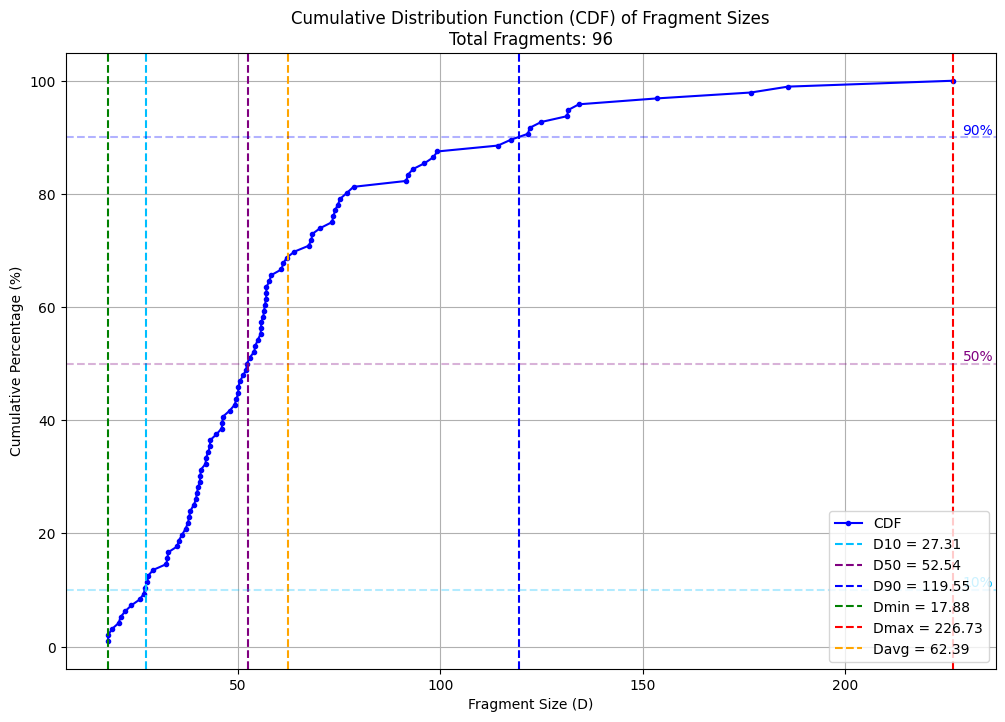

In [5]:
def draw_cdf_chart(diameters: np.ndarray): 
    D10 = np.percentile(diameters, 10)
    D50 = np.percentile(diameters, 50)
    D90 = np.percentile(diameters, 90)
    Dmin = diameters.min()
    Dmax = diameters.max()
    Davg = diameters.mean()

    cdf = np.arange(1, len(diameters) + 1) / len(diameters) * 100
    
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(diameters, cdf, marker='.', linestyle='-', label='CDF', color='blue')
    
    # Add vertical lines for D10, D50, D90
    plt.axvline(D10, color='deepskyblue', linestyle='--', label=f'D10 = {D10:.2f}')
    plt.axvline(D50, color='purple', linestyle='--', label=f'D50 = {D50:.2f}')
    plt.axvline(D90, color='blue', linestyle='--', label=f'D90 = {D90:.2f}')
    plt.axvline(Dmin, color='green', linestyle='--', label=f'Dmin = {Dmin:.2f}')
    plt.axvline(Dmax, color='red', linestyle='--', label=f'Dmax = {Dmax:.2f}')
    plt.axvline(Davg, color='orange', linestyle='--', label=f'Davg = {Davg:.2f}')
    
    # Add horizontal lines for 10%, 50%, 90%
    plt.axhline(10, color='deepskyblue', linestyle='--', alpha=0.3)
    plt.axhline(50, color='purple', linestyle='--', alpha=0.3)
    plt.axhline(90, color='blue', linestyle='--', alpha=0.3)
    
    max_x = diameters.max()  
    plt.text(max_x * 1.01, 10, '10%', color='deepskyblue', verticalalignment='bottom', fontsize=10)
    plt.text(max_x * 1.01, 50, '50%', color='purple', verticalalignment='bottom', fontsize=10)
    plt.text(max_x * 1.01, 90, '90%', color='blue', verticalalignment='bottom', fontsize=10)
    
    # Customize the plot
    plt.xlabel('Fragment Size (D)')
    plt.ylabel('Cumulative Percentage (%)')
    plt.title(f'Cumulative Distribution Function (CDF) of Fragment Sizes\nTotal Fragments: {len(diameters)}')
    plt.grid(True)
    plt.legend()
    
    # Save the plot
    plt.savefig('rock_fragment_cdf_annotated.png')
    plt.show()

draw_cdf_chart(diameters)

In [6]:
def get_overlaid_mask(image: Image, masks: np.ndarray):  
    image_array = np.array(image)
    if image_array.shape[-1] == 4:  # Handle RGBA images
        image_array = image_array[:, :, :3]

    # Resize binary masks to match the image dimensions
    resized_masks = [
        np.array(Image.fromarray(mask.astype(np.uint8)).resize(image.size, Image.NEAREST), dtype=bool)
        for mask in masks
    ]

    # Generate random colors for each mask
    num_masks = len(resized_masks)
    colors = [tuple(randint(0, 255) for _ in range(3)) for _ in range(num_masks)]

    # Overlay masks on the image
    overlaid_image = image_array.copy()
    for mask, color in zip(resized_masks, colors):
        overlaid_image[mask] = np.array(color, dtype=np.uint8) * 0.5 + overlaid_image[mask] * 0.5

    return overlaid_image


0: 736x1024 78 rock fragments, 2986.5ms
Speed: 7.2ms preprocess, 2986.5ms inference, 642.8ms postprocess per image at shape (1, 3, 736, 1024)


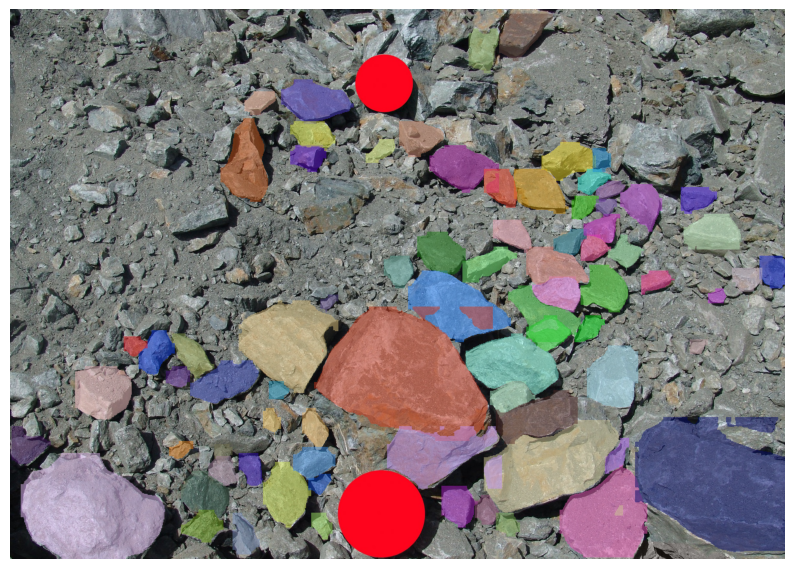

In [7]:
def visualize(img_path):
    img = Image.open(img_path).convert('RGB')
    masks = inference(img)
    overlaid_image = get_overlaid_mask(img, masks)
    plt.figure(figsize=(10, 10))
    plt.imshow(overlaid_image)
    plt.axis('off')
    plt.show()

visualize('/kaggle/input/gdgoc-hcmus-aic-calibration-image/img/117.jpg')

In [8]:
def random_inference(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(valid_extensions)]
    if not image_files:
        print("No valid images found in the directory.")
        return
    random_file = random.choice(image_files)
    file_path = os.path.join(directory, random_file)
    print(f"Visualizing inference on: {random_file}")
    visualize(file_path)

Visualizing inference on: 52.jpg

0: 1024x576 87 rock fragments, 2320.1ms
Speed: 6.1ms preprocess, 2320.1ms inference, 471.9ms postprocess per image at shape (1, 3, 1024, 576)


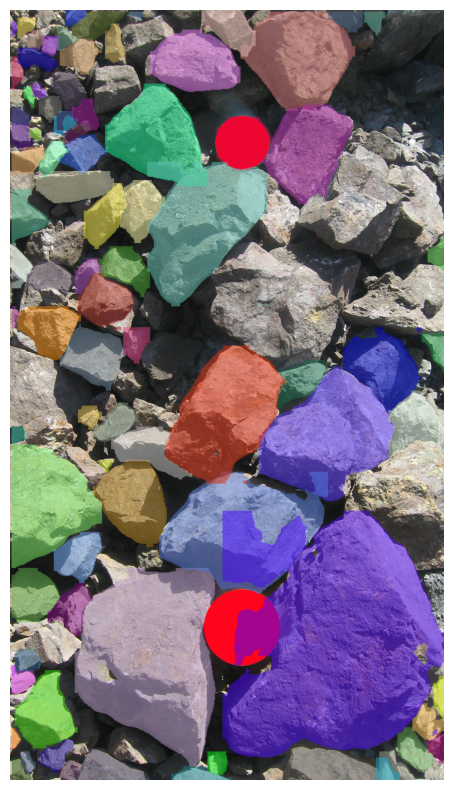

In [9]:
random_inference("/kaggle/input/gdgoc-hcmus-aic-calibration-image/img")

Visualizing inference on: 193.jpg

0: 576x1024 123 rock fragments, 2349.1ms
Speed: 5.7ms preprocess, 2349.1ms inference, 678.6ms postprocess per image at shape (1, 3, 576, 1024)


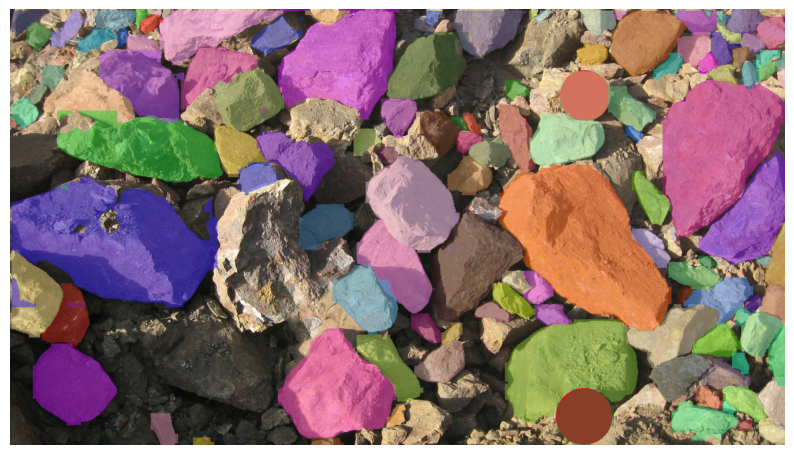

In [10]:
random_inference("/kaggle/input/gdgoc-hcmus-aic-calibration-image/img")

# Scaling pixel intensity of images with a calibration image 

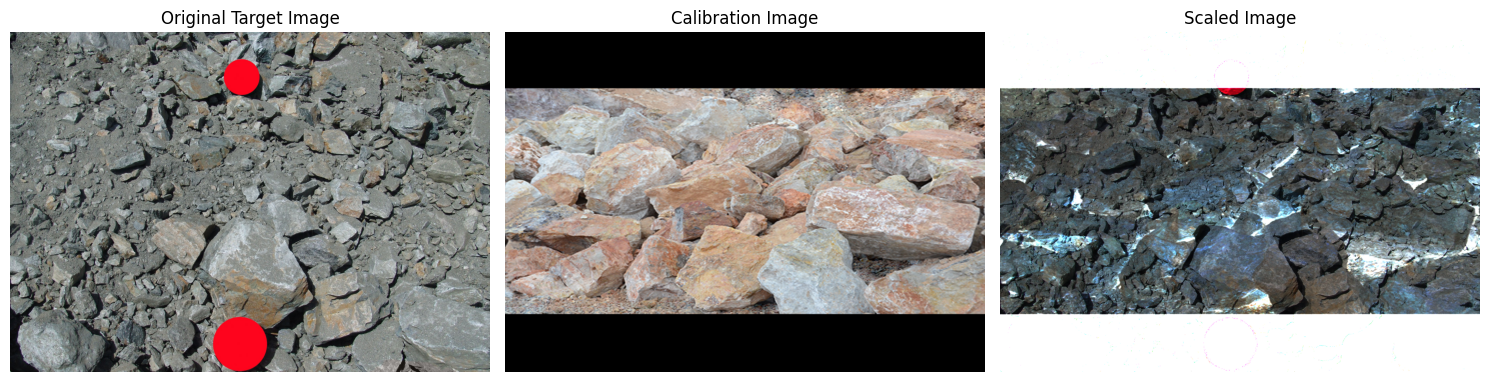

In [11]:
def load_image_as_array(path):
    img = Image.open(path).convert('RGB')  
    return np.asarray(img).astype(np.float32) / 255.0  

def scale_image(i1, i2, k2=0.0, epsilon=1e-8):
    # Mean intensity (k1) over valid pixels in calibration image
    k1 = np.mean(i2)

    # Avoid division by zero
    i2 = np.maximum(i2, epsilon)

    # Apply the correction: (i1 / i2) * k1 + k2
    corrected = (i1 / i2) * k1 + k2

    # Clip for visualization
    corrected = np.clip(corrected, 0, 1)

    # Optional: set unmasked areas to 0 (black)
    # corrected[~mask] = 0

    return corrected

# Paths to your images
target_path = '/kaggle/input/gdgoc-hcmus-aic-calibration-image/img/117.jpg'
calibration_path = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images/001.jpg'

def scale_intensity(target_path, calibration_path):
    # Load images
    target_img = load_image_as_array(target_path)
    calibration_img = load_image_as_array(calibration_path)
    
    # Resize calibration to match target if necessary
    if calibration_img.shape != target_img.shape:
        calibration_img = np.array(Image.fromarray((calibration_img * 255).astype(np.uint8)).resize(
            target_img.shape[1::-1], Image.BILINEAR)).astype(np.float32) / 255.0
    
    # Scale intensities
    scaled_img = scale_image(target_img, calibration_img)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(target_img)
    axes[0].set_title('Original Target Image')
    axes[0].axis('off')
    
    axes[1].imshow(calibration_img)
    axes[1].set_title('Calibration Image')
    axes[1].axis('off')
    
    axes[2].imshow(scaled_img)
    axes[2].set_title('Scaled Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

scale_intensity(target_path, calibration_path)

Scale intensities on: 181.jpg


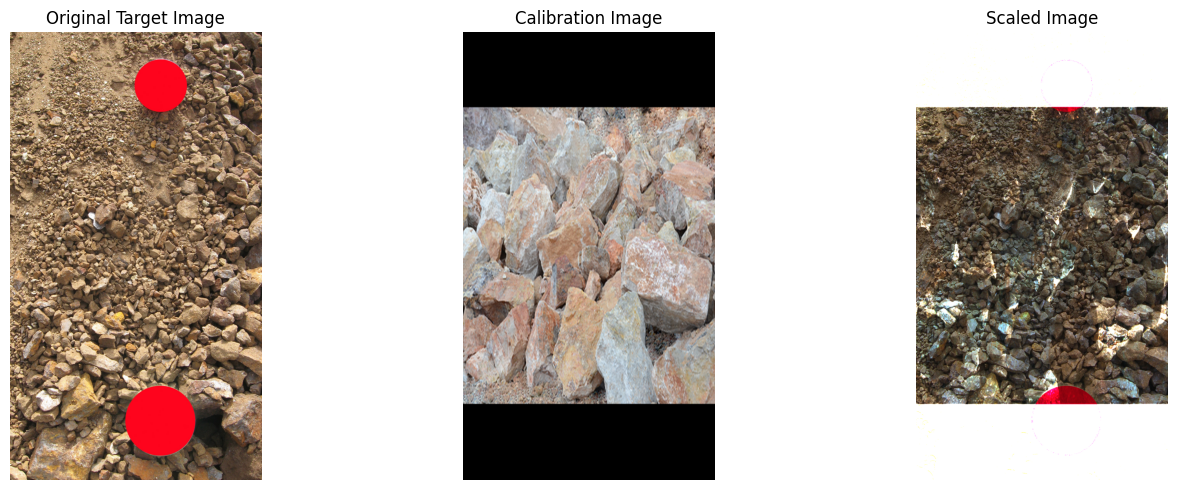

In [12]:
def random_scale_intensity(directory, calibration_path):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(valid_extensions)]
    if not image_files:
        print("No valid images found in the directory.")
        return
    random_file = random.choice(image_files)
    file_path = os.path.join(directory, random_file)
    print(f"Scale intensities on: {random_file}")
    scale_intensity(file_path, calibration_path)

random_scale_intensity(
    "/kaggle/input/gdgoc-hcmus-aic-calibration-image/img", 
    '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images/001.jpg'
)


0: 736x1024 22 rock fragments, 2841.8ms
Speed: 7.5ms preprocess, 2841.8ms inference, 165.3ms postprocess per image at shape (1, 3, 736, 1024)


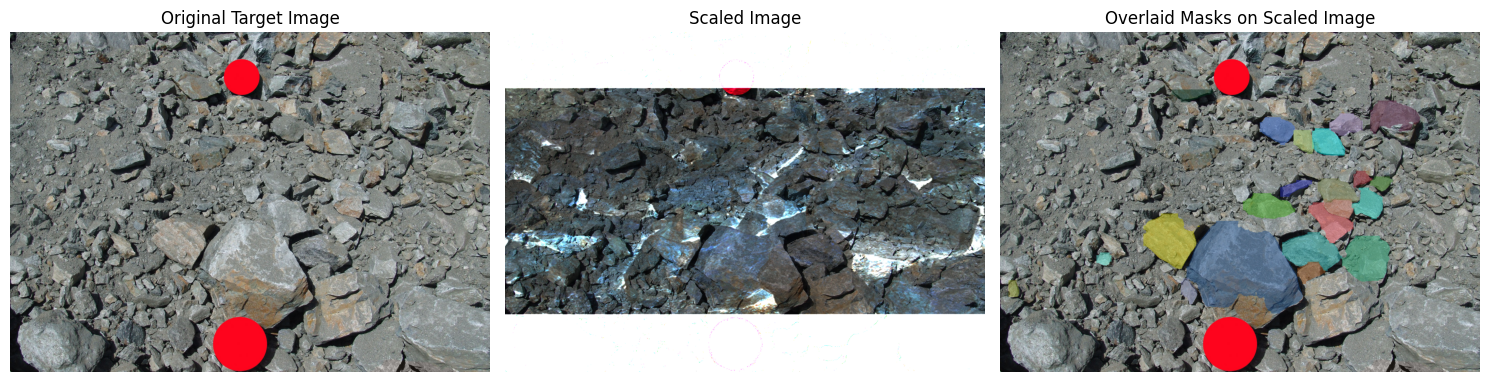

In [13]:
def inference_with_scale_intensity(target_path, calibration_path):
    # Load images
    target_img = load_image_as_array(target_path)
    calibration_img = load_image_as_array(calibration_path)
    
    # Resize calibration to match target if necessary
    if calibration_img.shape != target_img.shape:
        calibration_img = np.array(
            Image.fromarray((calibration_img * 255).astype(np.uint8)).resize(
                target_img.shape[1::-1], Image.BILINEAR
            )
        ).astype(np.float32) / 255.0
    
    # Scale intensities
    scaled_img = scale_image(target_img, calibration_img)
    scaled_img = Image.fromarray(np.uint8(scaled_img * 255))
    masks = inference(scaled_img)
    temp_img = Image.open(target_path).convert('RGB')
    overlaid_scaled_img = get_overlaid_mask(temp_img, masks)
    
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(target_img)
    axes[0].set_title('Original Target Image')
    axes[0].axis('off')
    
    axes[1].imshow(scaled_img)
    axes[1].set_title('Scaled Image')
    axes[1].axis('off')

    axes[2].imshow(overlaid_scaled_img)
    axes[2].set_title('Overlaid Masks on Scaled Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

inference_with_scale_intensity(target_path, calibration_path)

**Because we don't know what the best suitable calibration image for the target image is, this idea will not be used in production.**

# Detect red ball

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def _detect_calibration_object(img):
    """Detect calibration object (a red ball) in the image"""
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = mask1 | mask2

    kernel = np.ones((5, 5), np.uint8)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    calibration_balls = []
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if area < 100 or perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > 0.7:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            calibration_balls.append((int(x), int(y), int(radius)))

    if calibration_balls:
        calibration_balls.sort(key=lambda x: x[2], reverse=True)
        return True, calibration_balls[0]

    return False, None

def show_calibration_object(img_path):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise FileNotFoundError("Image not found. Please check the file path.")
    
    # Convert to RGB for detection and display
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Detect red ball
    found, ball = _detect_calibration_object(img_rgb)
    
    # Draw result on RGB image
    output_img = img_rgb.copy()
    if found:
        x, y, r = ball
        cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)
        cv2.putText(output_img, "Calibration Object", (x - 50, y - r - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
        print("No calibration object detected.")
    
    # Display with matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(output_img)
    plt.title("Calibration Object Detection")
    plt.axis("off")
    plt.show()

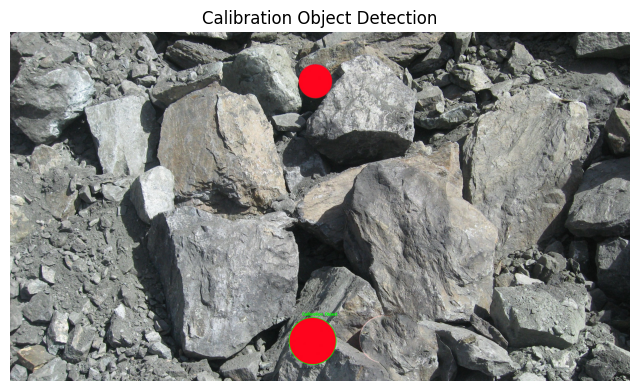

In [15]:
show_calibration_object('/kaggle/input/gdgoc-hcmus-aic-calibration-image/img/100.jpg')

No calibration object detected.


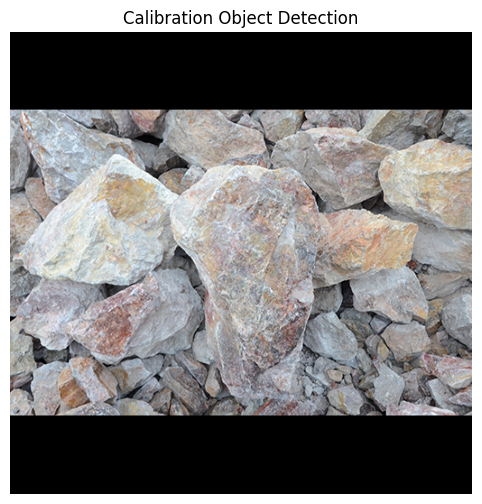

In [16]:
show_calibration_object('/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/val/images/007.jpg')

# Convert to real metrics

(1442, 1471, 112) True

image 1/1 /kaggle/input/gdgoc-hcmus-aic-calibration-image/img/100.jpg: 576x1024 28 rock fragments, 2122.3ms
Speed: 5.9ms preprocess, 2122.3ms inference, 158.0ms postprocess per image at shape (1, 3, 576, 1024)


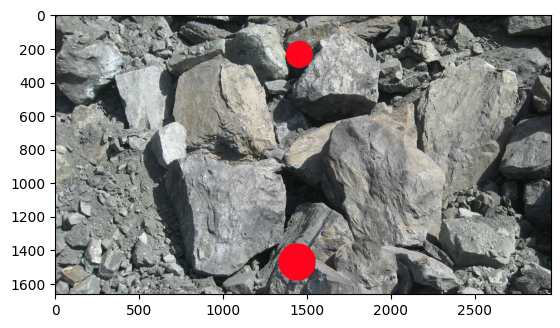

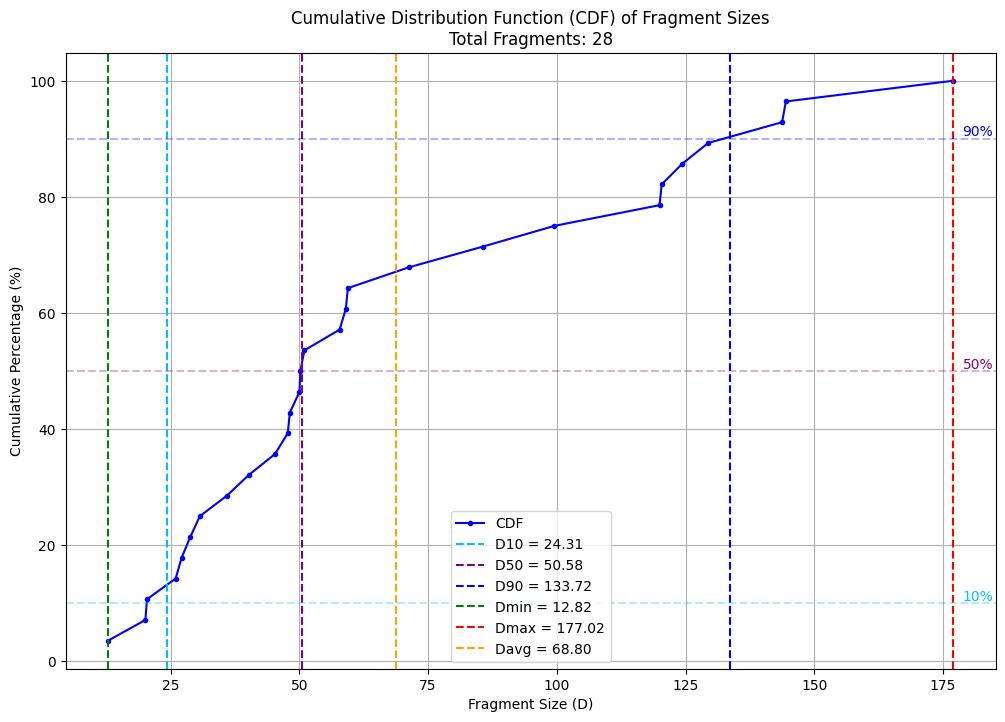

In [17]:
img_path = '/kaggle/input/gdgoc-hcmus-aic-calibration-image/img/100.jpg'
img = Image.open(img_path).convert("RGB")
plt.imshow(img)
is_calibrated, red_ball = _detect_calibration_object(np.array(img))

print(red_ball, is_calibrated)
(x, y, pixel_radius) = red_ball
centre = (x, y)

masks = inference(img_path)
diameters = get_diameter(masks)
draw_cdf_chart(diameters)

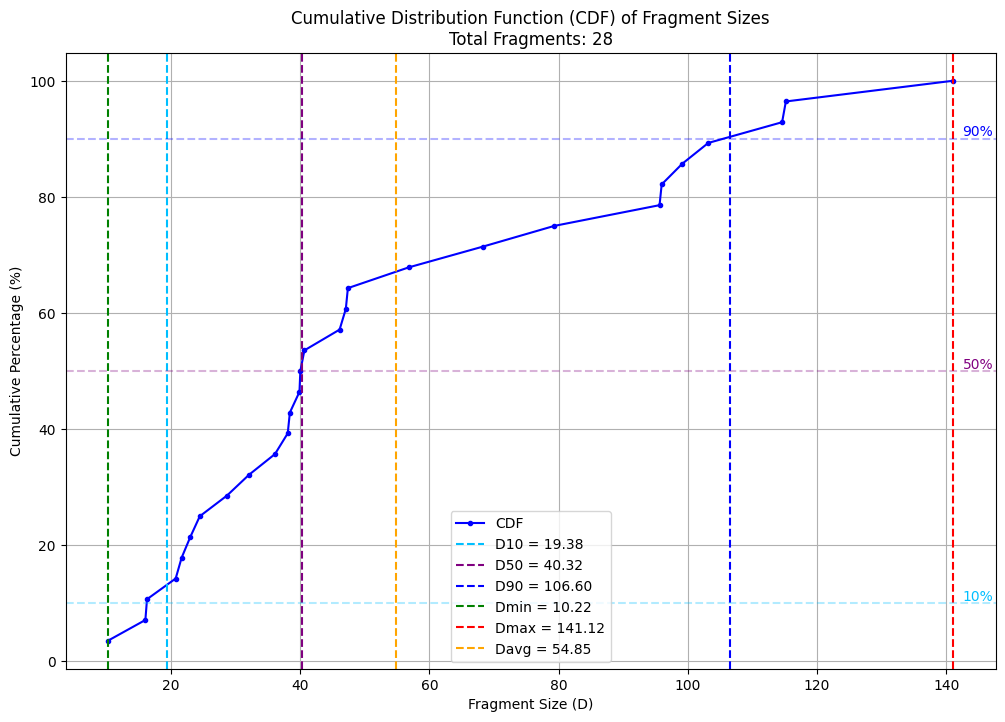

In [18]:
def calibrate(img: Image, masks: np.ndarray, diameters: np.ndarray, centre: tuple[float, float], real_radius: float, pixel_radius: float):
    """Calibrate the diameters using the red ball"""
    if pixel_radius == 0:
        print("Pixel radius is zero, cannot calibrate.")
        return diameters
    pixel_circle_area = np.pi * (pixel_radius ** 2)
    real_circle_area = np.pi * (real_radius ** 2)
    scaling_factor = real_circle_area / pixel_circle_area
    
    return np.array([d * scaling_factor for d in diameters])

real_radius = 100 # (cm)
diameters = calibrate(img, masks, diameters, centre, real_radius, pixel_radius)
draw_cdf_chart(diameters)